# **Notebook demonstrating the implementation of XGBoost and CNN on Fashion MNIST dataset**

### Importing the libraries

In [13]:
import copy
import gc
import random
from datetime import datetime
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import shap
import torch
import torch.nn.functional as F
import umap.umap_ as umap
from lime import lime_image
from PIL import Image
from skimage.color import gray2rgb, label2rgb, rgb2gray
from skimage.segmentation import mark_boundaries
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from skorch import NeuralNetClassifier
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from xgboost import XGBClassifier

from load_mnist import load_mnist

# check to see if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
RANDOM_STATE = 10
# Set this as per your processor cores
N_JOBS = 4
gc.collect()

59922

### 1. Data Preparation

In [14]:
X_train, y_train = load_mnist("fmnist_data/FashionMNIST/raw/", kind="train")
X_test, y_test = load_mnist("fmnist_data/FashionMNIST/raw/", kind="t10k")

labels = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}


# Creating a validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    stratify=y_train,  # To get balanced data by classes in two datasets.
    test_size=0.1,
    random_state=RANDOM_STATE,
)

# Converting into dataframes
df_X_train = pd.DataFrame(X_train)
df_y_train = pd.DataFrame(y_train)

df_X_test = pd.DataFrame(X_test)
df_y_test = pd.DataFrame(y_test)

df_X_train = df_X_train.add_prefix("pixel_")

### 2. Exploratory Data Analysis
- The Fashion MNIST dataset is a collection of 28x28 grayscale images of 10 different fashion categories, with a training set of 60,000 examples and a test set of 10,000 examples. Each image is associated with a label indicating the class of the clothing item it represents.
- Looking at the dimension of the data, seems like the images are flattened.
- Each image is represented as a row with 784 columns (28 * 28 = 784), each column containing a pixel density.


### Visualizing sample of images alongs with the classes

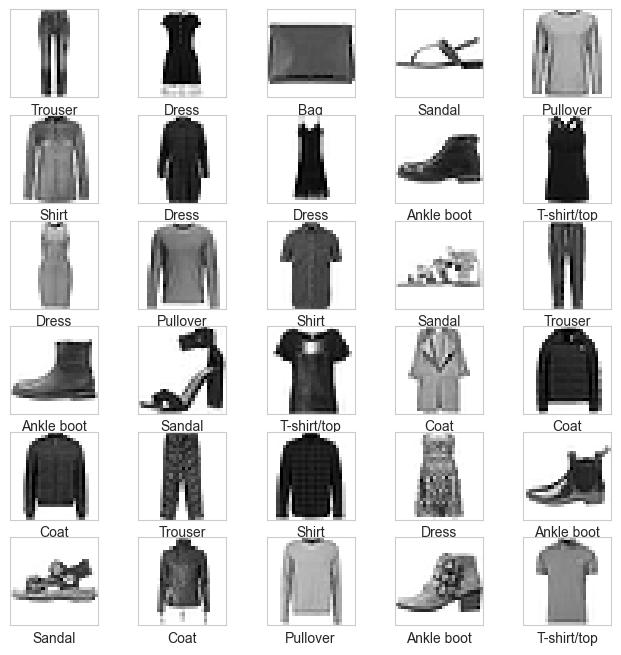

In [15]:
plt.figure(figsize=(8, 8))
# Show only the first 30 pictures
for i in range(30):
    plt.subplot(6, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train[i].reshape(28,28), cmap=plt.cm.binary)
    plt.xlabel(labels[y_train[i]])

### Dimensionality Reduction
We are using 2 methods of dimensinality reduction:
1. UMAP (Uniform Manifold Approximation and Projection):
    UMAP is a dimension reduction technique that can be used for visualisation. It is designed to capture both local and global relationships in high-dimensional data, providing an effective way to visualize complex patterns and structures in a lower-dimensional space.

2. TSNE (t-distributed Stochastic Neighbor Embedding):
    TSNE is an unsupervised non-linear dimensionality reduction technique for data exploration and visualizing high-dimensional data. It emphasizes preserving pairwise similarities between data points, making it effective for capturing local and global structures in the data

n_jobs value 4 overridden to 1 by setting random_state. Use no seed for parallelism.
The figure layout has changed to tight


Text(0.5, 0.98, 'Fashion MNIST clustered with UMAP')

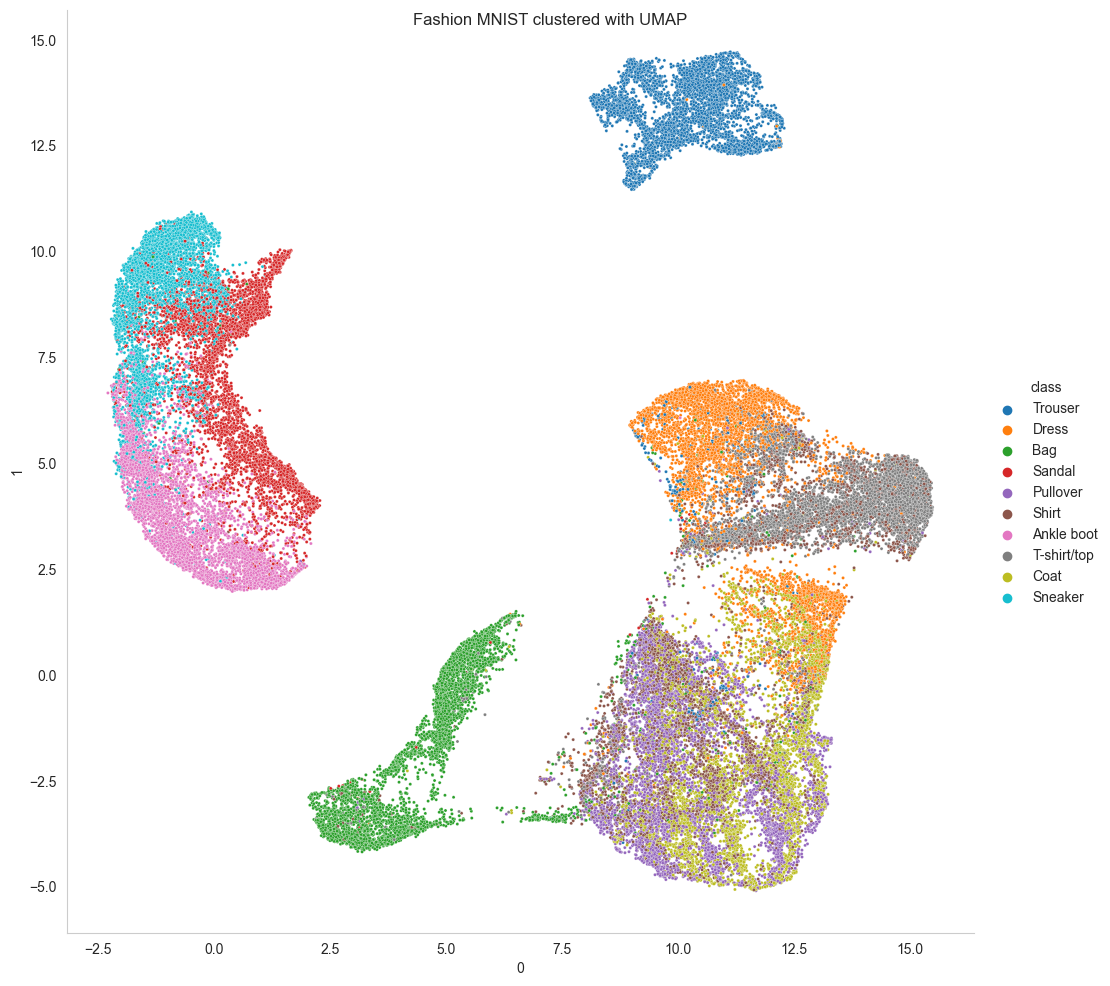

In [16]:
# Dimensionality Reduction using UMAP
umap_reduce = umap.UMAP(random_state=RANDOM_STATE, n_jobs=N_JOBS)
df_X_train_embedding = umap_reduce.fit_transform(
    df_X_train
)  ## Takes 3-4 minutes to fit

df_X_train_embedding = pd.DataFrame(df_X_train_embedding)
df_X_train_embedding['class'] = y_train
df_X_train_embedding['class'].replace(labels, inplace=True)

# Visualization
sns.set_style("whitegrid", {"axes.grid": False})
ax = sns.pairplot(
    x_vars=[0],  # column 0
    y_vars=[1],  # column 1
    data=df_X_train_embedding,
    hue="class",
    height=10,
    plot_kws={"s": 5},
)
ax.fig.suptitle("Fashion MNIST clustered with UMAP")

The figure layout has changed to tight


Text(0.5, 0.98, 'Fashion MNIST clustered with TSNE')

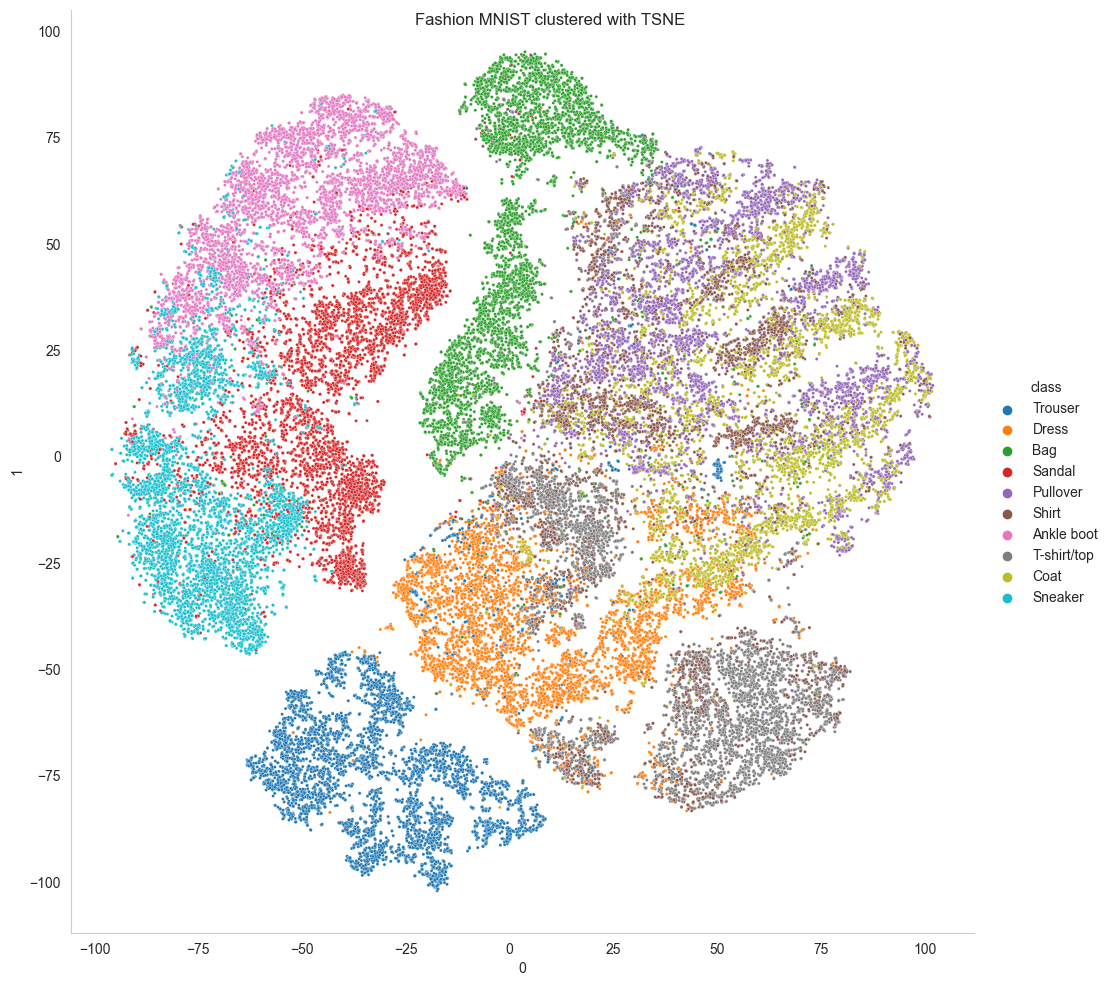

In [17]:
tsne_reduce = TSNE(random_state=RANDOM_STATE, n_jobs=N_JOBS)
df_X_train_tsne = tsne_reduce.fit_transform(X_train)  # Takes 3-4 minutes to fit

df_X_train_tsne = pd.DataFrame(df_X_train_tsne)
df_X_train_tsne["class"] = y_train
df_X_train_tsne["class"].replace(labels, inplace=True)
df_X_train_tsne.head()

sns.set_style("whitegrid", {"axes.grid": False})

# adjusting plot dots with plot_kws
ax = sns.pairplot(
    x_vars=[0],  # column 0
    y_vars=[1],  # column 1
    data=df_X_train_tsne,
    hue="class",
    height=10,
    plot_kws={"s": 5},
)

ax.fig.suptitle("Fashion MNIST clustered with TSNE")

- On applying UMAP and TSNE the data has been reduced into 2 dimensions.
- By above plot we can observe similarity between T-shirt/top, Pullover, Shirt, and Coat, when represented in 2-dim and also similarity between Sandal, Sneaker, Ankle Boot and trousers and bags are seperated from the rest of the classes as their shape is different.

### 3. Modelling

Algorithm Selection - We selected XGBoost and CNN.

Explanation - 
- The Fashion MNIST dataset is labelled and has high dimensional feature space.
- XGBoost classifier algorithm is chose for its robust classification capabilities on structured data, making it well suitable for Fashion MNIST dataset.
- Its ensemble approach, aggregating predictions from decision trees, excels at discerning intricate relationships in high-dimensional feature spaces.
- LeNet architecture-based Convolutional Neural Network (CNN) has been chosen to harness its proficiency in hierarchical feature extraction from image data.
- LeNet, tailored for image tasks, complements XGBoost by automatically capturing spatial hierarchies and local patterns within the grayscale images of fashion items. 

#### XGBoost Classifier

In [8]:
#XGBoost Classifier
xgb_base = XGBClassifier(
    random_state=RANDOM_STATE, n_jobs=N_JOBS, early_stopping_rounds=10, verbosity=1
)
xgb_base.fit(X_train, y_train, eval_set=[(X_val, y_val)])
print("Minimum Validation loss : ", xgb_base.best_score)
print("Best optimization iteration : ", xgb_base.best_iteration)

[0]	validation_0-mlogloss:1.40367
[1]	validation_0-mlogloss:1.10493
[2]	validation_0-mlogloss:0.91565
[3]	validation_0-mlogloss:0.78443
[4]	validation_0-mlogloss:0.68658
[5]	validation_0-mlogloss:0.61225
[6]	validation_0-mlogloss:0.55582
[7]	validation_0-mlogloss:0.50983
[8]	validation_0-mlogloss:0.47409
[9]	validation_0-mlogloss:0.44499
[10]	validation_0-mlogloss:0.42242
[11]	validation_0-mlogloss:0.40410
[12]	validation_0-mlogloss:0.38764
[13]	validation_0-mlogloss:0.37377
[14]	validation_0-mlogloss:0.36316
[15]	validation_0-mlogloss:0.35274
[16]	validation_0-mlogloss:0.34453
[17]	validation_0-mlogloss:0.33661
[18]	validation_0-mlogloss:0.33100
[19]	validation_0-mlogloss:0.32504
[20]	validation_0-mlogloss:0.31913
[21]	validation_0-mlogloss:0.31369
[22]	validation_0-mlogloss:0.30949
[23]	validation_0-mlogloss:0.30626
[24]	validation_0-mlogloss:0.30277
[25]	validation_0-mlogloss:0.29971
[26]	validation_0-mlogloss:0.29718
[27]	validation_0-mlogloss:0.29438
[28]	validation_0-mlogloss:0.2

In [9]:
# Model Evaluation
# Prediction on the train data
y_pred_train_xgb_base = xgb_base.predict(X_train)
print("Accuracy on train set : ", accuracy_score(y_train, y_pred_train_xgb_base))
print("\n")
print(
    "Confustion Matrix on train set : \n",
    confusion_matrix(y_train, y_pred_train_xgb_base),
)
print("\n")
print(
    "Classification Report on train set : \n",
    classification_report(y_train, y_pred_train_xgb_base),
)

Accuracy on train set :  0.9998518518518519


Confustion Matrix on train set : 
 [[5399    0    0    0    0    0    1    0    0    0]
 [   0 5400    0    0    0    0    0    0    0    0]
 [   0    0 5397    0    2    0    1    0    0    0]
 [   0    0    0 5400    0    0    0    0    0    0]
 [   0    0    0    0 5398    0    2    0    0    0]
 [   0    0    0    0    0 5400    0    0    0    0]
 [   2    0    0    0    0    0 5398    0    0    0]
 [   0    0    0    0    0    0    0 5400    0    0]
 [   0    0    0    0    0    0    0    0 5400    0]
 [   0    0    0    0    0    0    0    0    0 5400]]


Classification Report on train set : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5400
           1       1.00      1.00      1.00      5400
           2       1.00      1.00      1.00      5400
           3       1.00      1.00      1.00      5400
           4       1.00      1.00      1.00      5400
           5       1.0

In [10]:
# Prediction on the test data
y_pred_test_xgb_base = xgb_base.predict(X_test)
print("Accuracy on test set : ", accuracy_score(y_test, y_pred_test_xgb_base))
print("\n")
print(
    "Confustion Matrix on test set : \n",
    confusion_matrix(y_test, y_pred_test_xgb_base),
)
print("\n")
print(
    "Classification Report on test set : \n",
    classification_report(y_test, y_pred_test_xgb_base),
)

Accuracy on test set :  0.8951


Confustion Matrix on test set : 
 [[866   0  18  21   5   1  85   0   4   0]
 [  3 971   1  17   4   0   3   0   1   0]
 [ 14   1 833   8  81   0  59   0   4   0]
 [ 17   3  13 908  25   0  32   0   2   0]
 [  0   0  82  29 833   0  54   0   2   0]
 [  0   0   1   0   0 973   0  17   0   9]
 [139   1  97  21  72   1 659   0  10   0]
 [  0   0   0   0   0   5   0 968   0  27]
 [  1   1   5   3   2   1   8   4 975   0]
 [  0   0   0   0   0   5   1  29   0 965]]


Classification Report on test set : 
               precision    recall  f1-score   support

           0       0.83      0.87      0.85      1000
           1       0.99      0.97      0.98      1000
           2       0.79      0.83      0.81      1000
           3       0.90      0.91      0.90      1000
           4       0.82      0.83      0.82      1000
           5       0.99      0.97      0.98      1000
           6       0.73      0.66      0.69      1000
           7       0.95      

## Hyperparameter Tuning and Optimization 

- Performing Hyper Parameter Tuning using grid search for the XGBoost Model

In [15]:
# '''Please note that this cell (Hyperparameter Tuning) takes more than one hour to fit.'''

# xgb_grid_parameters = {"max_depth" : [5],
#                        "n_estimators" : [100],
# #                        "early_stopping_rounds" : [10],
#                        "reg_lambda" : [0.001, 0.01, 0.1, 1, 10], # L2/ Ridge regularization
#                        "colsample_bytree" : [0.8, 0.9]
#                       }
 
# kFold = StratifiedKFold(n_splits = 6)

# xgb_model_gs01 = GridSearchCV(estimator = XGBClassifier(random_state = RANDOM_STATE,
#                                                         verbose = 1,
#                                                         early_stopping_rounds = 10,
# #                                                         tree_method = "gpu_hist",
# #                                                         predictor = "gpu_predictor",
# #                                                         device = "cuda",
# #                                                         gpu_id = 0
#                                                        ),
#                               param_grid = xgb_grid_parameters,
#                               cv = kFold,
#                               scoring = "f1_weighted",
#                               n_jobs = N_JOBS,
#                               verbose = 1
#                               )
# ## Takes around 1 hr
# xgb_model_gs01.fit(X_train, y_train, eval_set = [(X_val, y_val)])
# print("Best Parameters as per grid search : ", xgb_model_gs01.best_params_)

'Please note that the cells of Hyperparameter Tuning has been commented out as it takes more than one hour to fit.'

In [7]:
# y_pred_train_xgb_gs01 = xgb_model_gs01.predict(X_train)

# print("Accuracy on train set : ", accuracy_score(y_train, y_pred_train_xgb_gs01))
# print("\n")

# print("Confustion Matrix on train set : \n", confusion_matrix(y_train, y_pred_train_xgb_gs01))
# print("\n")

# print("Classification Report on train set : \n", classification_report(y_train, y_pred_train_xgb_gs01))

# y_pred_test_xgb_gs01 = xgb_model_gs01.predict(X_test_fin)

# print("Accuracy on test set : ", accuracy_score(y_test_fin, y_pred_test_xgb_gs01))
# print("\n")

# print("Confustion Matrix on test set : \n", confusion_matrix(y_test_fin, y_pred_test_xgb_gs01))
# print("\n")

# print("Classification Report on test set : \n", classification_report(y_test_fin, y_pred_test_xgb_gs01))

Training the XGBoost model with the best parameters from grid search

In [16]:
xgb_model_fin = XGBClassifier(random_state = RANDOM_STATE,
                              n_jobs = N_JOBS,
                              verbose = 1,
                              early_stopping_rounds = 10,
                              colsample_bytree = 0.9,
                              max_depth = 5,
                              n_estimators = 100,
                              reg_lambda = 10)

xgb_model_fin.fit(X_train,
                  y_train,
                  eval_set = [(X_val, y_val)],
                  verbose = 1
                 )

[13:29:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:1.46552
[1]	validation_0-mlogloss:1.16879
[2]	validation_0-mlogloss:0.97894
[3]	validation_0-mlogloss:0.84549
[4]	validation_0-mlogloss:0.74233
[5]	validation_0-mlogloss:0.66412
[6]	validation_0-mlogloss:0.60426
[7]	validation_0-mlogloss:0.55756
[8]	validation_0-mlogloss:0.52025
[9]	validation_0-mlogloss:0.48882
[10]	validation_0-mlogloss:0.46293
[11]	validation_0-mlogloss:0.44201
[12]	validation_0-mlogloss:0.42493
[13]	validation_0-mlogloss:0.40970
[14]	validation_0-mlogloss:0.39737
[15]	validation_0-mlogloss:0.38664
[16]	validation_0-mlogloss:0.37723
[17]	validation_0-mlogloss:0.36893
[18]	validation_0-mlogloss:0.36209
[19]	validation_0-mlogloss:0.35589
[20]	validation_0-mlogloss:0.34973
[21]	validation_0-mlogloss:0.34481
[22]	validation_0-mlogloss:0.34011
[23]	validation_0-mloglo

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=4, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

### Optimized XGBoost's Model Evaluation

#### Train Set

In [17]:
#Classification Report
y_pred_train_xgb_fin = xgb_model_fin.predict(X_train)

print("Accuracy on train set : ", accuracy_score(y_train, y_pred_train_xgb_fin))
print("\nClassification Report on train set : \n", classification_report(y_train, y_pred_train_xgb_fin))

Accuracy on train set :  0.9866666666666667

Classification Report on train set : 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      5400
           1       1.00      1.00      1.00      5400
           2       0.97      0.97      0.97      5400
           3       0.99      0.99      0.99      5400
           4       0.97      0.98      0.97      5400
           5       1.00      1.00      1.00      5400
           6       0.97      0.94      0.96      5400
           7       1.00      1.00      1.00      5400
           8       1.00      1.00      1.00      5400
           9       1.00      1.00      1.00      5400

    accuracy                           0.99     54000
   macro avg       0.99      0.99      0.99     54000
weighted avg       0.99      0.99      0.99     54000



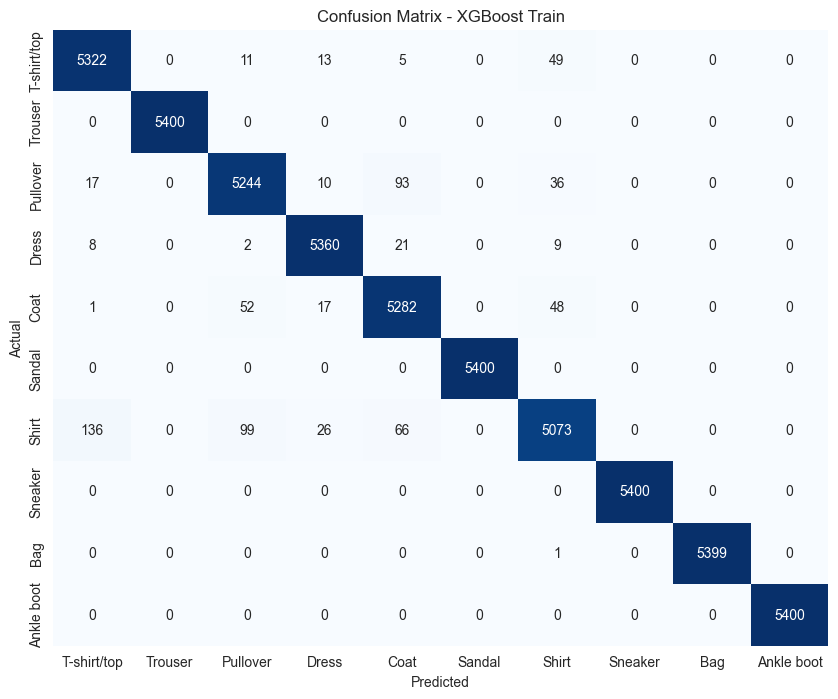

In [18]:
#Confusion Matrix
cm_xgb_fin = confusion_matrix(y_train, y_pred_train_xgb_fin)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_xgb_fin, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=labels.values(), yticklabels=labels.values(),)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost Train')
plt.show()

#### Test Set

In [19]:
#Classification Report
y_pred_test_xgb_fin = xgb_model_fin.predict(X_test)

print("Accuracy on test set : ", accuracy_score(y_test, y_pred_test_xgb_fin))
print("\nClassification Report on test set : \n", classification_report(y_test, y_pred_test_xgb_fin))

Accuracy on test set :  0.8943

Classification Report on test set : 
               precision    recall  f1-score   support

           0       0.84      0.87      0.85      1000
           1       0.99      0.97      0.98      1000
           2       0.80      0.83      0.82      1000
           3       0.90      0.92      0.91      1000
           4       0.81      0.82      0.82      1000
           5       0.99      0.97      0.98      1000
           6       0.72      0.66      0.69      1000
           7       0.95      0.96      0.96      1000
           8       0.97      0.97      0.97      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



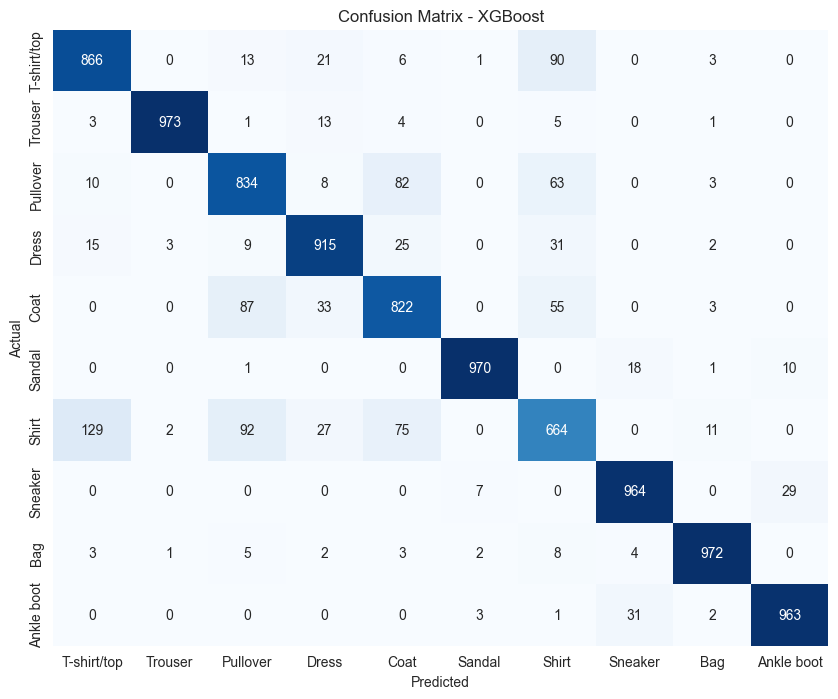

In [20]:
#Confusion Matrix
cm_xgb_fin_test = confusion_matrix(y_test, y_pred_test_xgb_fin)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_xgb_fin_test, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=labels.values(), yticklabels=labels.values(),)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost')
plt.savefig("confusion_matrix_xgboost.jpg",bbox_inches="tight")
plt.show()

Inferences - 
- The XGBoost model has an accuracy of 98% on Train set and 89.4% on the Test set.
- The confusion matrix suggests that the model tends to misclassify between tshirt/top, pullover, coat, shirt. This might be because they are all similar in shape.
- This can be validated through Model Interpretability methods implemented below.

## Interpretability
Understanding which features contributed most in learning

Text(0.5, 1.0, 'XGBoost feature importances')

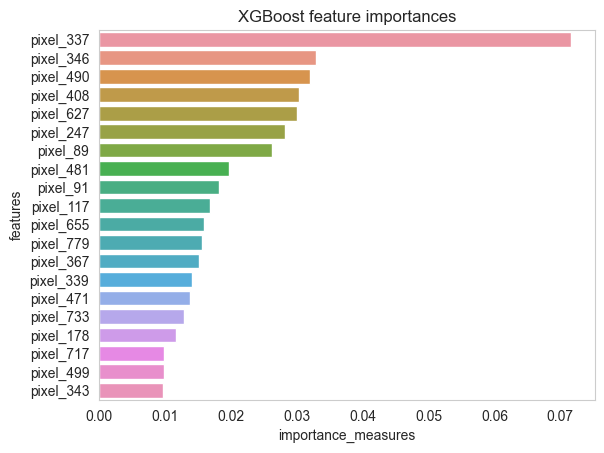

In [23]:
df_feature_importance = pd.DataFrame(columns=["features", "importance_measures"])

df_feature_importance["features"] = df_X_train.columns
df_feature_importance["importance_measures"] = xgb_model_fin.feature_importances_

df_feature_importance.sort_values(
    by="importance_measures", ascending=False, inplace=True
)

sns.barplot(
    x="importance_measures", y="features", data=df_feature_importance.iloc[:20, :]
)
plt.title("XGBoost feature importances")

- The higher the score, the more it's important in making the prediction.
- By default, feature importances use "gain" metric, this is a measure of the improvement in accuracy brought by a feature to the branches it is on.
- The XGBoost model's feature importance suggests that the Pixel 337 has highest importance, this means that pixel 337 has been frequently used to split data across all the trees in the ensembles.

Exploring two popular methods to interpret black box model predictions:
1. SHAP(SHapley Additive exPlanations)
2. LIME(Local Interpretable Model-Agnostic Explanations)

### SHAP

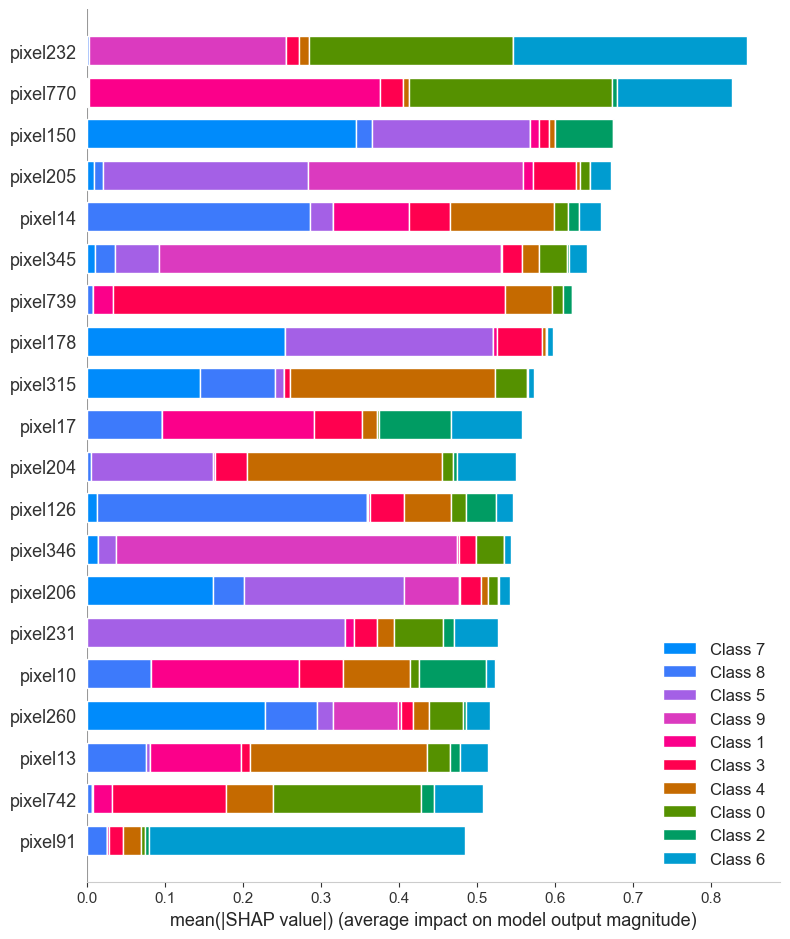

In [24]:
#Utilising the Tree Explainer module of shap as our data is trained on the XGBoost model
# SHAP
explainer = shap.TreeExplainer(xgb_model_fin,tree_limit=100)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(
    shap_values,
    X_test,
    plot_type="bar",
    feature_names=[f"pixel{i}" for i in range(X_train.shape[1])],
)

- The summary plot above shows the average impact of the pixels on model output in descending order. From the plot, it can also be inferred which pixel has highest influence for a model to predict that particular class.

- It can be observed that pixel 232 has the highest average impact on model output and Class 0(Tshirt/Top), Class 6(Shirt) utlisie this pixel(not surprised as their shape is similar). 

- While we understand the pixel values with highest importance from above, it is difficult to infer in this manner and hence visualizing the shap values as image below.

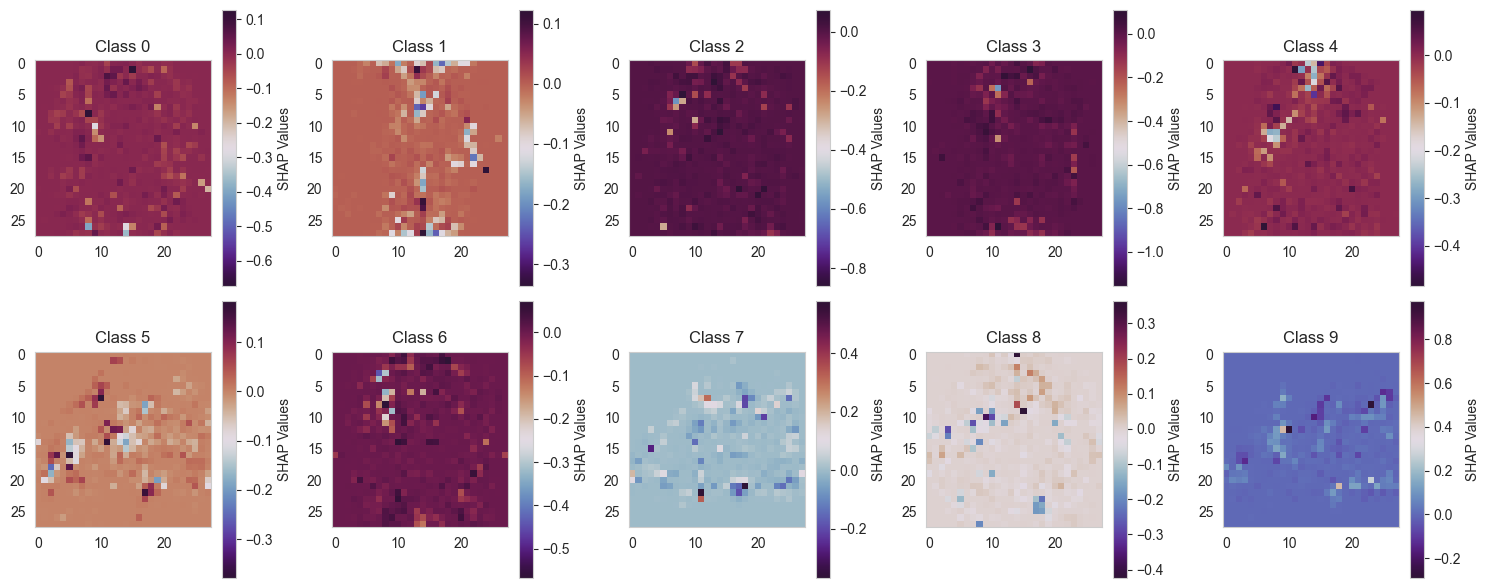

In [25]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
axs = axs.ravel()

for sample_index in range(X_test.shape[0]):
    for class_index in range(10):
        shap_values_sample_class = shap_values[class_index][sample_index, :].reshape(28, 28)
        im = axs[class_index].imshow(shap_values_sample_class, 
                                     cmap='twilight_shifted',
                                     vmin=np.min(shap_values_sample_class), 
                                     vmax=np.max(shap_values_sample_class))
        axs[class_index].set_title('Class {}'.format(class_index))
        cbar = plt.colorbar(im, ax=axs[class_index])
        cbar.set_label('SHAP Values')
    break
plt.savefig("shap_xgboost.jpg",bbox_inches="tight")
plt.tight_layout()
plt.show()

From the above plot, it can be inferred that the pixels encapsulating the shape of the fashion item has more influence on the XGBoost Model's predictions.

### LIME
- Utilizing the "lime" package's "lime_image" module, we can explain the predictions of images classified by an XGBoost classifier. This involves determining which specific parts (pixels) of the image played a significant role in influencing the classifier's prediction.
- The explain_instance method of the explainer object requires an RGB image, and the implemented predict function is referenced as classifier_fn.
- When calling get_image_and_mask, it takes a class for which an explanation is desired and outputs the image along with the mask. The mask identifies the pixels influencing the prediction.
- To visualize the contributing pixels, both the mask and the image are plotted using the mark_boundaries function from the skimage segmentation library.

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


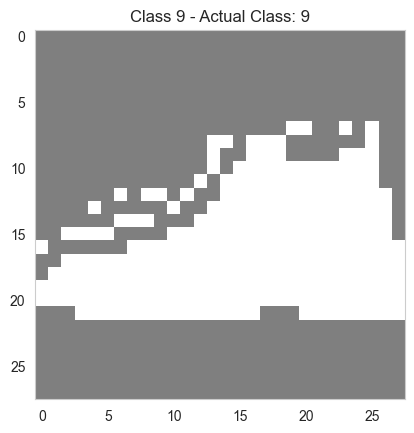

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


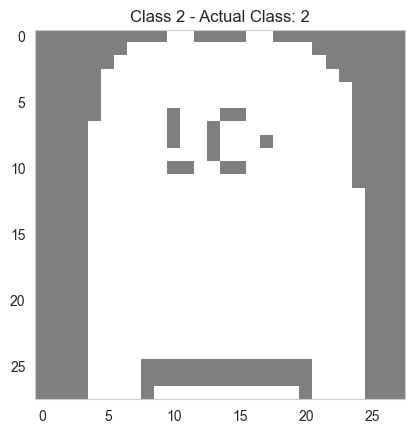

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


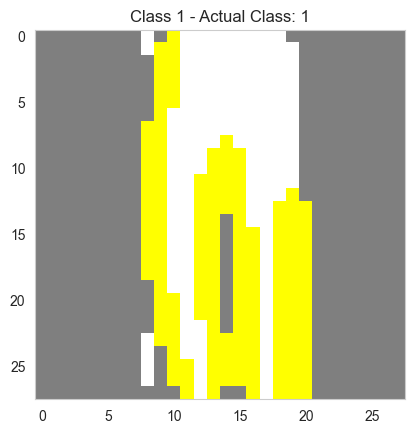

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


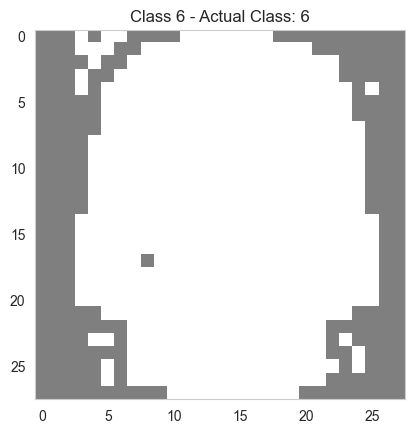

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


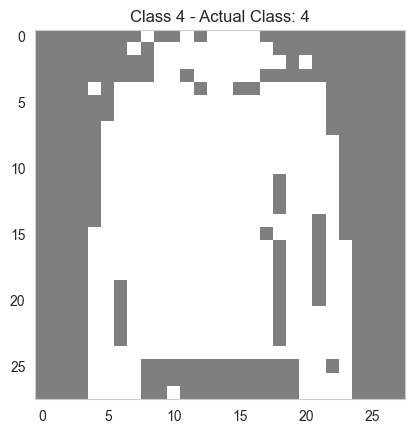

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


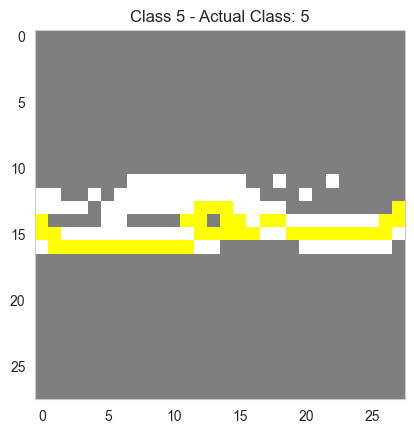

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


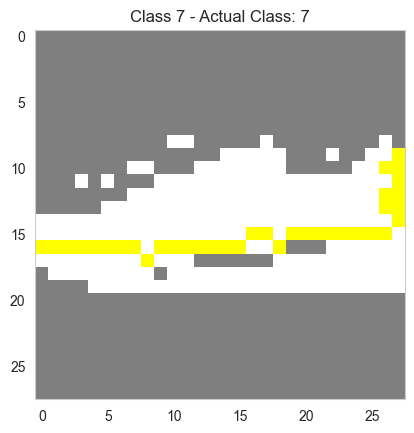

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


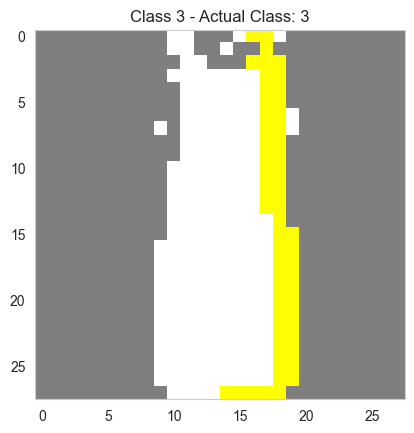

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


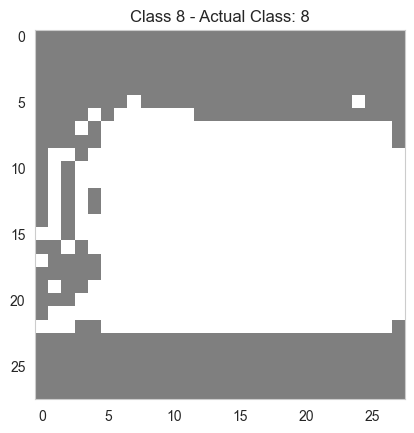

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


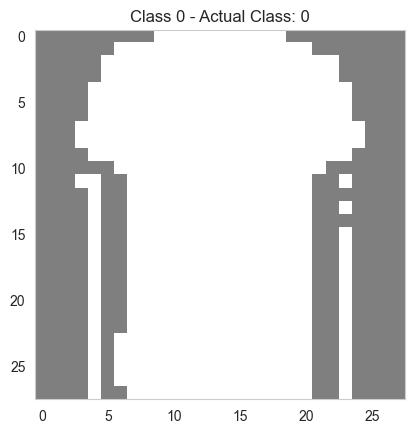

In [26]:
# LIME
explainer = lime_image.LimeImageExplainer()


def pred_fn(imgs):
    tot_probs = []
    for img in imgs:
        grayimg = rgb2gray(img)
        probs = xgb_model_fin.predict_proba(grayimg.reshape(1, -1))[0]
        tot_probs.append(probs)
    return tot_probs


selected_classes = set()  # Initialize a set to keep track of selected classes

for idx in range(len(X_test)):
    predicted_class = xgb_model_fin.predict(X_test[idx].reshape(1, -1))[0]
    if predicted_class not in selected_classes:
        explanation = explainer.explain_instance(
            gray2rgb(X_test[idx].reshape(28, 28)), classifier_fn=pred_fn, top_labels=10
        )

        temp, mask = explanation.get_image_and_mask(predicted_class, num_features=784)

        plt.imshow(mark_boundaries(temp / 2 + 0.5, mask), cmap="viridis")
        plt.title(f"Class {predicted_class} - Actual Class: {y_test[idx]}")
        plt.show()

        selected_classes.add(predicted_class)

    if len(selected_classes) == 10:
        break

- From the explanations above and as observed already in SHAP, the pixels outlining the shape of the fashion item appear to play a significant role in the prediction.

# CNN Model

## Getting the data

Train set has 48000 instances
Test set has 10000 instances
Validation set has 12000 instances


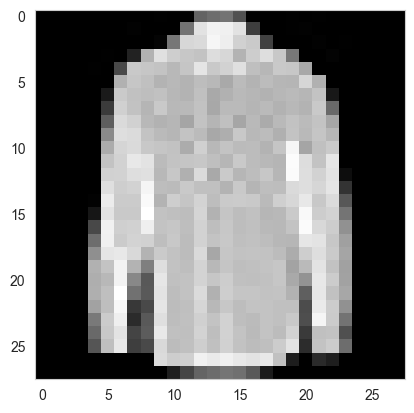

In [19]:
# Define a transform to normalize the data

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)


def get_datasets(data_dir="./fmnist_data"):
    # Download the train and test data
    train_dataset = datasets.FashionMNIST(
        data_dir, download=True, train=True, transform=transform
    )
    test_dataset = datasets.FashionMNIST(
        data_dir, download=True, train=False, transform=transform
    )

    # Define the size of the training and validation sets
    train_size = int(0.8 * len(train_dataset))  # 80% for training
    val_size = len(train_dataset) - train_size  # 20% for validation

    # Split the training dataset
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

    return (train_dataset, test_dataset, val_dataset)


def get_data_loaders(train_dataset, test_dataset, val_dataset):
    # Create DataLoader for training, testing and validation
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=100, shuffle=True
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=100, shuffle=True
    )
    val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)
    return train_loader, test_loader, val_loader


# Datasets
train_dataset, test_dataset, val_dataset = get_datasets()
# Data Loaders
train_loader, test_loader, val_loader = get_data_loaders(*get_datasets())

# Labels in the data and their corresponding integer mapping
label_mapping = {
    0: "T-shirt/Top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

# Report split sizes
print("Train set has {} instances".format(len(train_dataset)))
print("Test set has {} instances".format(len(test_dataset)))
print("Validation set has {} instances".format(len(val_dataset)))

# Plotting the image
plt.imshow(train_dataset[0][0][0], cmap="gray")

## Building the Model

In [56]:
class CNN(nn.Module):
    def __init__(
        self,
        first_conv_out=6,
        second_conv_out=16,
        kernel_size=5,
        first_fc_out=120,
        second_fc_out=64,
        dropout_prob=0.3,
        activation_function="relu",
    ):
        super(CNN, self).__init__()

        # Intializing the hyperameters
        self.first_conv_out = first_conv_out
        self.second_conv_out = second_conv_out
        self.kernel_size = kernel_size
        self.first_fc_out = first_fc_out
        self.second_fc_out = second_fc_out
        self.activation_function = activation_function
        self.dropout_prob = dropout_prob

        # Initializing the Layers
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=first_conv_out,
            kernel_size=kernel_size,
            padding=2,
        )
        self.avgpool1 = nn.AvgPool2d(2, stride=2)

        self.conv2 = nn.Conv2d(
            in_channels=first_conv_out,
            out_channels=second_conv_out,
            kernel_size=kernel_size,
            padding=0,
        )

        # Fully connected layers
        self.fc1 = nn.Linear(
            in_features=second_conv_out * kernel_size**2, out_features=first_fc_out
        )
        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc2 = nn.Linear(in_features=first_fc_out, out_features=second_fc_out)
        self.fc3 = nn.Linear(in_features=second_fc_out, out_features=10)

        # Activation function
        if activation_function == "relu":
            self.activation = nn.ReLU()
        elif activation_function == "tanh":
            self.activation = nn.Tanh()
        elif activation_function == "sigmoid":
            self.activation = nn.Sigmoid()
        else:
            raise ValueError("Unsupported activation function. Use 'relu' or 'tanh'.")

    def forward(self, x):
        out = self.avgpool1(self.activation(self.conv1(x)))
        out = self.avgpool1(self.activation(self.conv2(out)))

        out = out.view(out.size(0), -1)
        out = self.activation(self.fc1(out))
        out = self.activation(self.fc2(out))
        out = self.fc3(out)

        return out

In [51]:
from torchsummary import summary
model = CNN()
summary(model, (1, 28,28), batch_size=100)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [100, 6, 28, 28]             156
              ReLU-2           [100, 6, 28, 28]               0
         AvgPool2d-3           [100, 6, 14, 14]               0
            Conv2d-4          [100, 16, 10, 10]           2,416
              ReLU-5          [100, 16, 10, 10]               0
         AvgPool2d-6            [100, 16, 5, 5]               0
            Linear-7                 [100, 120]          48,120
              ReLU-8                 [100, 120]               0
            Linear-9                  [100, 64]           7,744
             ReLU-10                  [100, 64]               0
           Linear-11                  [100, 10]             650
Total params: 59,086
Trainable params: 59,086
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.30
Forward/ba

In [33]:
# validating the model
def validate(model, data):
    total = 0
    correct = 0

    for i, (images, labels) in enumerate(data):
        x = model(images)
        value, pred = torch.max(x, 1)
        total += x.size(0)
        correct += torch.sum(pred == labels)
    return correct * 100 / total

In [34]:
# training function
def train(
    model=CNN(),
    epochs=1,
    learning_rate=1e-3,
    criterion=nn.CrossEntropyLoss(),
    device="cpu",
):
    train_accuracies = []
    test_accuracies = []
    max_accuracy = 0
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            pred = model(images)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()

        train_accuracy = float(validate(model, train_loader))
        train_accuracies.append(train_accuracy)
        test_accuracy = float(validate(model, test_loader))
        test_accuracies.append(test_accuracy)

        print("\nEpoch : ", epoch + 1)
        print("Train Accuracy :", train_accuracy, "%")
        print("Test Accuracy :", test_accuracy, "%")

        if test_accuracy > max_accuracy:
            best_model = copy.deepcopy(model)
            max_accuracy = test_accuracy
            print("Saving the best model with accuracy", test_accuracy)

    # Accuracy plots.
    plt.figure(figsize=(10, 7))
    plt.plot(train_accuracies, color="green", linestyle="-", label="train accuracy")
    plt.plot(test_accuracies, color="blue", linestyle="-", label="validataion accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("CNN Accuracy vs Epochs")
    plt.legend()

    return best_model


Epoch :  1
Train Accuracy : 81.30833435058594 %
Test Accuracy : 80.48999786376953 %
Saving the best model with accuracy 80.48999786376953

Epoch :  2
Train Accuracy : 83.85416412353516 %
Test Accuracy : 82.91000366210938 %
Saving the best model with accuracy 82.91000366210938

Epoch :  3
Train Accuracy : 87.1500015258789 %
Test Accuracy : 86.66999816894531 %
Saving the best model with accuracy 86.66999816894531

Epoch :  4
Train Accuracy : 87.44166564941406 %
Test Accuracy : 86.4000015258789 %

Epoch :  5
Train Accuracy : 88.89583587646484 %
Test Accuracy : 87.54000091552734 %
Saving the best model with accuracy 87.54000091552734

Epoch :  6
Train Accuracy : 89.27708435058594 %
Test Accuracy : 87.75 %
Saving the best model with accuracy 87.75

Epoch :  7
Train Accuracy : 90.12083435058594 %
Test Accuracy : 88.7300033569336 %
Saving the best model with accuracy 88.7300033569336

Epoch :  8
Train Accuracy : 90.6312484741211 %
Test Accuracy : 89.2300033569336 %
Saving the best model with

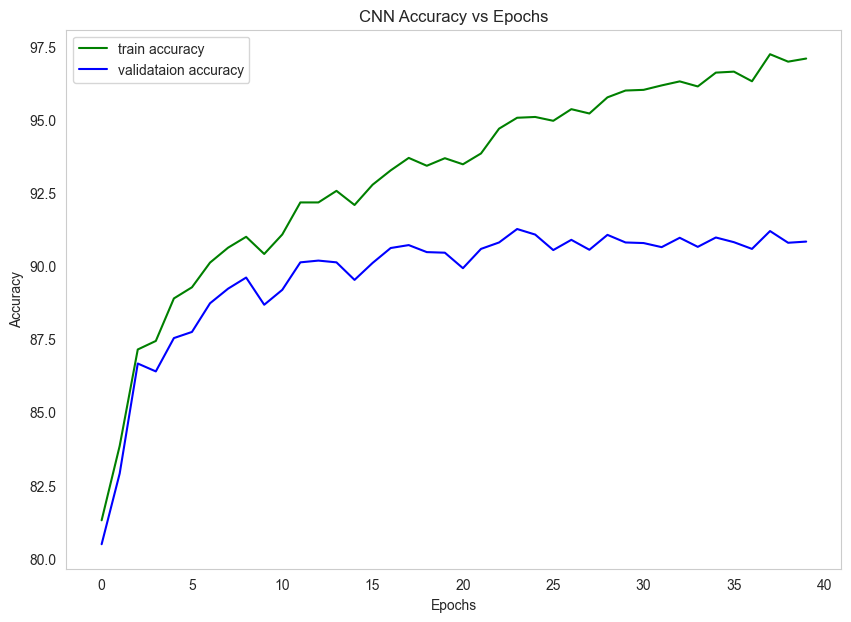

In [42]:
# training the model and saving the best model
date = datetime.now().date()

model = CNN()
learning_rate = 1e-3

trained_model = train(model=model, epochs=40, learning_rate=learning_rate)
model_path = "./saved_models/best_model_{}.pth".format(date)
torch.save(trained_model, model_path)

In [71]:
#Class wise accuracies of the model on the test data
trained_model = torch.load('saved_models/best_model_2023-11-22.pth')
class_correct = [0.0 for _ in range(10)]
total_correct = [0.0 for _ in range(10)]

with torch.no_grad():
    for img, labels in test_loader:
        img, labels = img.to(device), labels.to(device)
        test = Variable(img)
        outputs = trained_model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()

        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1

for i in range(10):
    print(
        "Accuracy of {}: {:.2f}%".format(
            label_mapping[i], class_correct[i] * 100 / total_correct[i]
        )
    )

Accuracy of T-shirt/Top: 87.70%
Accuracy of Trouser: 97.70%
Accuracy of Pullover: 88.00%
Accuracy of Dress: 90.60%
Accuracy of Coat: 86.40%
Accuracy of Sandal: 98.10%
Accuracy of Shirt: 73.80%
Accuracy of Sneaker: 95.60%
Accuracy of Bag: 98.60%
Accuracy of Ankle Boot: 96.20%


Model Test Accuracy : 0.9127
     0    1    2    3    4    5    6    7    8    9
0  877    0   13   24    3    0   74    0    9    0
1    2  977    1   11    2    0    5    0    2    0
2   19    1  880   11   41    0   47    0    1    0
3   18    7   10  906   36    0   20    0    3    0
4    1    2   49   18  864    0   63    0    3    0
5    0    0    0    0    0  981    0   11    3    5
6  115    0   57   26   54    0  738    0   10    0
7    0    0    0    0    0   17    0  956    3   24
8    2    1    4    2    2    1    2    0  986    0
9    0    0    0    0    0    6    1   31    0  962


Text(0.5, 1.0, 'Confusion Matrix for the CNN Classifier')

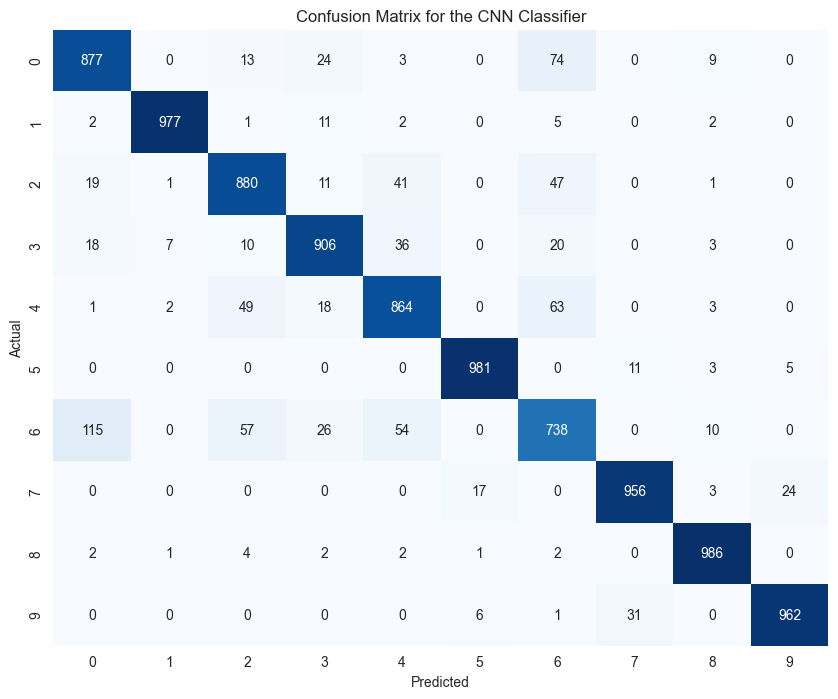

In [68]:
def predict_dataloader(model, data):
    y_pred = []
    y_true = []
    for i, (images, labels) in enumerate(data):
        x = model(images)
        value, pred = torch.max(x, 1)
        y_pred.extend(list(pred.numpy()))
        y_true.extend(list(labels.numpy()))
    return np.array(y_pred), np.array(y_true)

trained_model = torch.load('saved_models/best_model_2023-11-22.pth')
y_pred, y_true = predict_dataloader(trained_model, test_loader)
print("Model Test Accuracy :", accuracy_score(y_true=y_true, y_pred=y_pred))
conf_matrix = pd.DataFrame(
    confusion_matrix(y_true=y_true, y_pred=y_pred, labels=np.arange(0, 10))
)
print(conf_matrix)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for the CNN Classifier')

## Out-of-sample image testing

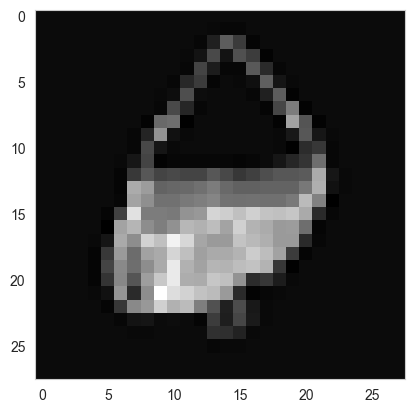

Predicted: Bag, Probabiity: 98.7016499042511%


In [78]:
# Testing on out of sample dataset
path = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR20SdRy4SKbY8LWQAN8J-H5C_q54RGRfidcYMoOuLKcg&s"  # We can use any other image link here


def out_of_sample_image_transformer(path):
    r = requests.get(path)
    with BytesIO(r.content) as f:
        image = Image.open(f).convert(mode="L")
        image = image.resize((28, 28))
        x = (255 - np.expand_dims(np.array(image), -1)) / 255.0
    return x


def out_of_sample_validation(image, model, device=device):
    with torch.no_grad():
        pred = model(torch.unsqueeze(transform(image), axis=1).float().to(device))
        return F.softmax(pred, dim=1).cpu().numpy()


# Displaying the image
def displaying_out_of_sample_image_from_path(path):
    r = requests.get(path)
    with BytesIO(r.content) as f:
        image = Image.open(f).convert(mode="L")
        image = image.resize((28, 28))
        x = (255 - np.expand_dims(np.array(image), -1)) / 255.0
    plt.imshow(x.squeeze(-1), cmap="gray")
    plt.show()


displaying_out_of_sample_image_from_path(path)

# Predicting the out-of-sample image
transformed_image = out_of_sample_image_transformer(path)
out_of_sample_pred = out_of_sample_validation(transformed_image, trained_model, device)
pred_id = np.argmax(out_of_sample_pred)
print(
    f"Predicted: {label_mapping[pred_id]}, Probabiity: {out_of_sample_pred[0][pred_id]*100}%"
)

## Hyperparameter Tuning

In [46]:
# Hyperparameter tuning
# Define hyperparameters for grid search
param_grid = {
    "module__first_conv_out": [4, 8, 16, 32],
    "module__second_conv_out": [4, 8, 16, 32],
    "module__first_fc_out": [128, 256, 512],
    "module__second_fc_out": [128, 256, 512],
    "module__dropout_prob": [0.2, 0.3, 0.4, 0.5],
    "module__activation_function": ["relu", "tanh", "sigmoid"],
}

# Define the Skorch wrapper
model = NeuralNetClassifier(
    CNN,
    criterion=nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    max_epochs=20,
    verbose=False,
    train_split=None,
)

# Perform grid search
samples, labels = next(iter(val_loader))
grid_search = GridSearchCV(
    estimator=model, param_grid=param_grid, scoring="accuracy", n_jobs=-1, cv=3
)
grid_search.fit(samples, labels)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'module__activation_function': 'relu', 'module__dropout_prob': 0.5, 'module__first_conv_out': 16, 'module__first_fc_out': 512, 'module__second_conv_out': 4, 'module__second_fc_out': 512}



Epoch :  1
Train Accuracy : 81.4937515258789 %
Test Accuracy : 80.79000091552734 %
Saving the best model with accuracy 80.79000091552734

Epoch :  2
Train Accuracy : 86.20833587646484 %
Test Accuracy : 85.05999755859375 %
Saving the best model with accuracy 85.05999755859375

Epoch :  3
Train Accuracy : 87.01041412353516 %
Test Accuracy : 85.79000091552734 %
Saving the best model with accuracy 85.79000091552734

Epoch :  4
Train Accuracy : 87.40416717529297 %
Test Accuracy : 86.16000366210938 %
Saving the best model with accuracy 86.16000366210938

Epoch :  5
Train Accuracy : 89.26875305175781 %
Test Accuracy : 87.66999816894531 %
Saving the best model with accuracy 87.66999816894531

Epoch :  6
Train Accuracy : 89.30000305175781 %
Test Accuracy : 87.73999786376953 %
Saving the best model with accuracy 87.73999786376953

Epoch :  7
Train Accuracy : 90.40416717529297 %
Test Accuracy : 88.75 %
Saving the best model with accuracy 88.75

Epoch :  8
Train Accuracy : 90.42708587646484 %
Tes

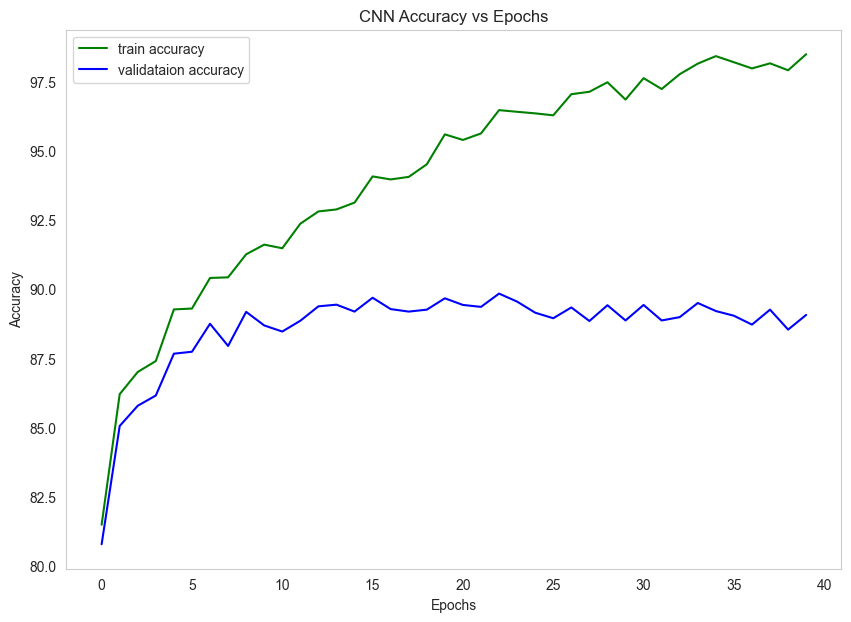

In [47]:
# Train the model with the best hyperparameters
best_model = CNN(
    first_conv_out=best_params["module__first_conv_out"],
    second_conv_out=best_params["module__second_conv_out"],
    first_fc_out=best_params["module__first_fc_out"],
    second_fc_out=best_params["module__second_fc_out"],
    dropout_prob=best_params["module__dropout_prob"],
    activation_function=best_params["module__activation_function"],
)

criterion = nn.CrossEntropyLoss()
trained_model = train(
    epochs=40,
    model=best_model,
    criterion=criterion,
)

Plot the feature maps for the convulution layers

#### LIME 

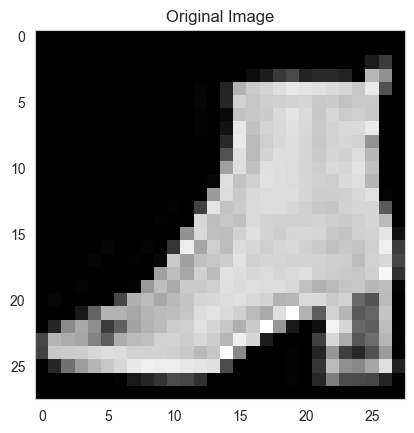

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


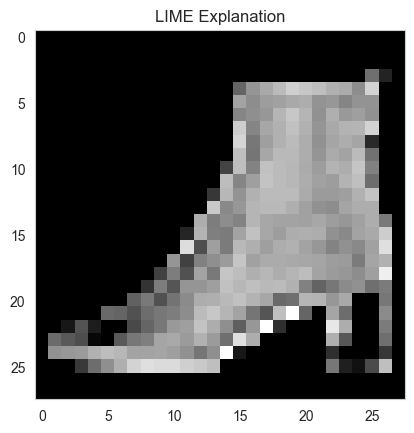

In [58]:
model = torch.load('saved_models/best_model_2023-11-22.pth')
# Choose a sample image for explanation
samples, labels = next(iter(test_loader))
image = samples[0]
label = int(labels[0].numpy())

plt.imshow(image.squeeze().numpy(), cmap="gray")
plt.title("Original Image")
plt.show()


def predict_fn(img):
    gray_images = rgb2gray(img).reshape(-1, 1, 28, 28)
    outputs = model(torch.from_numpy(gray_images).float())
    probabilities = F.softmax(outputs, dim=1)
    return probabilities.detach().numpy()


explainer = lime_image.LimeImageExplainer()

# Explain the prediction for the sample image
explanation = explainer.explain_instance(
    image.squeeze(0),
    predict_fn,
    top_labels=1,
    hide_color=0,
    num_samples=1000,
    batch_size=1,
    labels=labels,
)

# Display the LIME explanation
temp, mask = explanation.get_image_and_mask(
    label, positive_only=True, num_features=5, hide_rest=True
)
plt.imshow(mark_boundaries(temp, mask), cmap="gray")
plt.title("LIME Explanation")
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

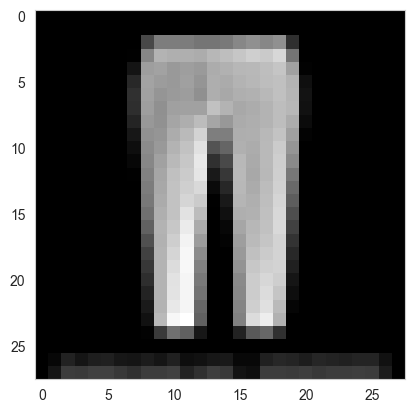

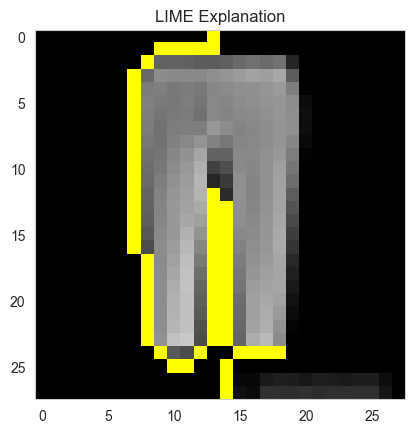

In [59]:
# Choose an out of sample image for explanation
path = "https://www.shutterstock.com/image-photo/light-grey-formal-mens-trousers-260nw-1096296503.jpg"
trained_model = torch.load('saved_models/best_model_2023-11-22.pth')
transformed_image = out_of_sample_image_transformer(path)
prediction = np.argmax(out_of_sample_validation(transformed_image, trained_model, device))

transformed_image = transformed_image.transpose((2, 0, 1))
explanation = explainer.explain_instance(
    transformed_image.squeeze(0),
    predict_fn,
    top_labels=1,
    hide_color=0,
    num_samples=1000,
    batch_size=1,
    labels=labels,
)

# Display the LIME explanation
displaying_out_of_sample_image_from_path(path)
temp, mask = explanation.get_image_and_mask(
    prediction, positive_only=True, num_features=5, hide_rest=True
)
plt.imshow(mark_boundaries(temp, mask), cmap="gray")
plt.title("LIME Explanation")
plt.show()

## Business Insights
The application of classification models, such as XGBoost and CNN, in the fashion industry can provide valuable business insights and impact various aspects of the business. 

1. Quality Control and Assurance:
    Implementing image classification as part of quality control processes can help identify defects or inconsistencies in clothing items during the manufacturing or sourcing stages. This ensures that only high-quality products reach customers.

2. Enhanced Customer Experience:
    Accurate image classification enables better search and recommendation systems. Customers can easily find the products they are looking for, leading to a more satisfying and efficient shopping experience.

3. Improved Product Categorization:
    The use of machine learning models facilitates accurate and automated categorization of clothing items. This can significantly improve the efficiency of managing product inventory and categorizing products on e-commerce platforms.